In [28]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
#Extract the meaningful parameters of the faces dataset
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [29]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
#Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
# You’ll compress each face from n_features = h*w pixels down to 150 coefficients.
# These top directions (principal components) are the “eigenfaces.” They capture the largest variance patterns across faces.

In [6]:
# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean

In [10]:
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False) # S captures amount of variance
components = V[:n_components] # Pick top 150 components or eigenfaces ehich represents new “directions” in this space which PCA finds
eigenfaces = components.reshape((n_components, h, w))

In [11]:
#project into PCA subspace
X_transformed = np.dot(X_train, components.T) # Convert train and test data in PCA subspace with 150 features
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

(966, 150)
(322, 150)


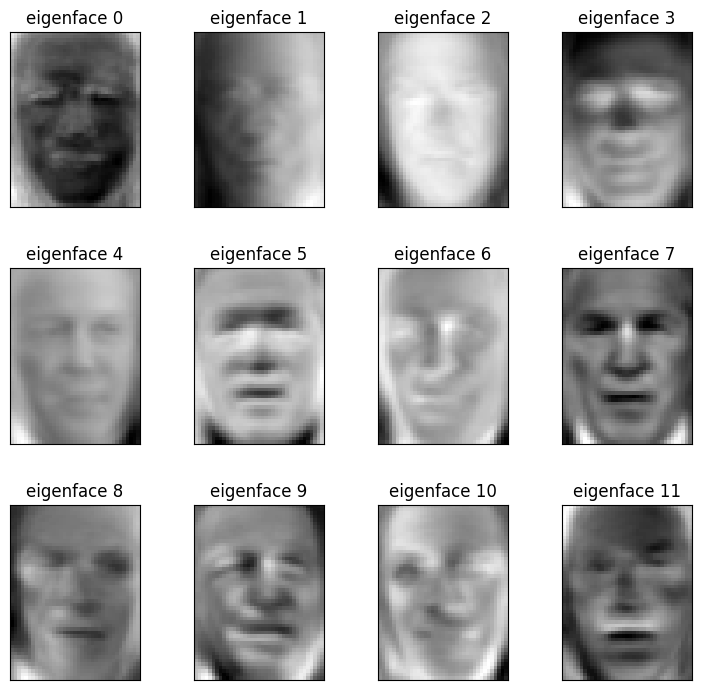

In [15]:
import matplotlib.pyplot as plt
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

(966,)


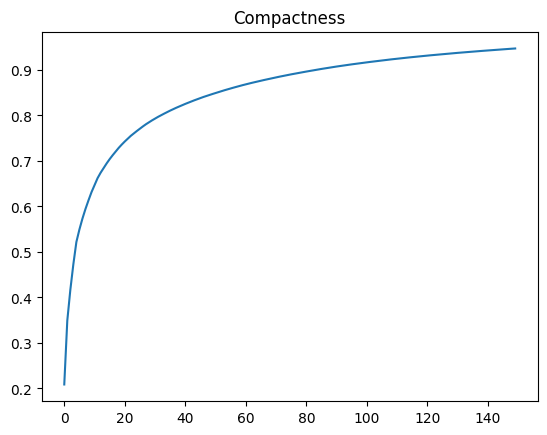

In [16]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 4 3 3 3 3 6 3 3 4 1 1 3 3 0 1 4 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 1 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 5 3 1 3 3 4 3 5 3 4 3 3 6 6 3 3
 3 2 3 6 3 3 6 3 3 3 3 3 3 3 3 1 3 6 3 3 1 1 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 3 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 3 3 6 6 6 3 3 4 3 3 6 3 3 3 3 1 3 3 1 3
 6 1 1 3 3 3 3 3 6 3 3 3 6 5 5 1 3 3 5 1 3 3 3 3 3 1 5 3 3 3 3 5 3 3 3 1 3
 3 3 3 3 2 4 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 4 3 3 5 3 3 3 3 3 1 3 3 3 3
 3 1 1 3 3 3 1 3 3 3 3 3 3 1 3 6 3 3 3 4 2 3 4 3 3 3 3 4 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 5 6 1 6 1 1 1 3 3 3 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 3 3 5 3 3 3
 3 5 3 3 3 6 3 3 1 3 3 3 1 3 3 3 1 3 1 3 3 3 3 3 4 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True False
  True False  True  True False  True  True  True  True False  True False
  True  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False  True
 False  T

In [18]:
import torch

def pca_torch(X, n_components):
    """
    PCA using PyTorch, equivalent to NumPy eigenfaces PCA.

    Args:
        X: input data [n_samples, n_features] (torch tensor)
        n_components: number of principal components to keep
    Returns:
        mean: mean face (torch tensor)
        components: top eigenfaces [n_components, n_features]
        X_proj: projection of X into PCA subspace
    """
    # 1. Center data
    mean = X.mean(dim=0)
    X_centered = X - mean

    # 2. SVD decomposition
    U, S, Vh = torch.linalg.svd(X_centered, full_matrices=False)

    # 3. Select top components
    components = Vh[:n_components]  # [n_components, n_features]

    # 4. Project data into PCA subspace
    X_proj = X_centered @ components.T

    return mean, components, X_proj


In [19]:
# Suppose X_train is your training data as a torch tensor
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)

mean, components, X_train_proj = pca_torch(X_train_torch, n_components=150)

# Transform test set
X_test_centered = X_test_torch - mean
X_test_proj = X_test_centered @ components.T

print("Train PCA shape:", X_train_proj.shape)
print("Test PCA shape:", X_test_proj.shape)


Train PCA shape: torch.Size([966, 150])
Test PCA shape: torch.Size([322, 150])


In [20]:
# Uses torch.linalg.svd, which is backed by highly optimized BLAS/LAPACK or CUDA libraries.

# Data is stored in PyTorch tensors (torch.Tensor).

# Easy to integrate directly into deep learning pipelines (e.g., use PCA before feeding into a neural net).

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# ---------------------------
# Load LFW dataset
# ---------------------------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images   # shape = (n_samples, h, w)
y = lfw_people.target
n_samples, h, w = X.shape
n_classes = len(lfw_people.target_names)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Add channel dimension (N, C, H, W) and convert to torch tensors
X_train = torch.tensor(X_train[:, np.newaxis, :, :], dtype=torch.float32)
X_test  = torch.tensor(X_test[:, np.newaxis, :, :], dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

print("X_train shape:", X_train.shape)  # e.g. (966, 1, 50, 37)

# Data loaders
# Wrap arrays in datasets, then loaders handle mini-batches and shuffling for you
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True) # Shuffle is True means each batch will be different for each epoch
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# ---------------------------
# CNN Model
# ---------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (C=1 → 32 filters)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # (32 → 32 filters)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (h//2) * (w//2), 128)  # after pooling size halves
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------
# Training
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 25
for epoch in range(1, epochs+1):
    model.train()
    train_loss, correct = 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
        pred = outputs.argmax(1)
        correct += (pred == yb).sum().item()
    acc = correct / len(train_ds)
    print(f"Epoch {epoch}: Train Loss={train_loss/len(train_ds):.4f}, Train Acc={acc:.4f}")

# ---------------------------
# Evaluation
# ---------------------------
model.eval()
correct = 0
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        outputs = model(Xb)
        pred = outputs.argmax(1)
        correct += (pred == yb).sum().item()
test_acc = correct / len(test_ds)
print(f"Final Test Accuracy: {test_acc:.4f}")


X_train shape: torch.Size([966, 1, 50, 37])
Epoch 1: Train Loss=1.7378, Train Acc=0.3903
Epoch 2: Train Loss=1.6200, Train Acc=0.4193
Epoch 3: Train Loss=1.2763, Train Acc=0.5383
Epoch 4: Train Loss=0.9256, Train Acc=0.6874
Epoch 5: Train Loss=0.6172, Train Acc=0.7805
Epoch 6: Train Loss=0.4177, Train Acc=0.8665
Epoch 7: Train Loss=0.3257, Train Acc=0.8975
Epoch 8: Train Loss=0.2569, Train Acc=0.9286
Epoch 9: Train Loss=0.2175, Train Acc=0.9275
Epoch 10: Train Loss=0.1220, Train Acc=0.9658
Epoch 11: Train Loss=0.0833, Train Acc=0.9793
Epoch 12: Train Loss=0.0612, Train Acc=0.9865
Epoch 13: Train Loss=0.0361, Train Acc=0.9979
Epoch 14: Train Loss=0.0173, Train Acc=0.9990
Epoch 15: Train Loss=0.0153, Train Acc=0.9979
Epoch 16: Train Loss=0.0145, Train Acc=0.9979
Epoch 17: Train Loss=0.0066, Train Acc=1.0000
Epoch 18: Train Loss=0.0042, Train Acc=1.0000
Epoch 19: Train Loss=0.0033, Train Acc=1.0000
Epoch 20: Train Loss=0.0028, Train Acc=1.0000
Epoch 21: Train Loss=0.0024, Train Acc=1.0000